# Graduation Rate Prediction
## Derek Caramella
## 2 May 2022

# Table of Contents
1. [Modules](#modules)
    1. [Import Modules](#import-modules)
2. [ETL](#etl)
    1. [Preprocessing Graduation Rate DataFrame](#preprocess-graduation-rate)
    2. [Preprocessing Accountability Status DataFrame](#preprocess-accountability-status)
    3. [Preprocessing Expenditures DataFrame](#preprocess-expenditures)
    4. [Preprocessing Inexperienced DataFrame](#preprocess-inexperienced)
    5. [Preprocessing Institution Grouping DataFrame](#preprocess-institution)
    6. [Preprocessing Teach Out of of Certification DataFrame](#preprocess-tech-out)
    7. [Merge](#merge)
2. [Descriptive Analysis](#descriptive-analysis)
    1. [Descriptive Statistics](#descriptive-statistics)
    2. [Correlation Matrix](#corr-matrix)
    3. [Graduation Rate Histogram](#grad-rate-hist)
    4. [Funding per Student Boxenplot](#fund-per-student-boxen)
    5. [Graduation Rate by Funding per Student](#grad-rate-fund-per-student)
    6. [PCA](#pca)
    7. [Teacher Representation](#teacher-representation)
    8. [Overall Status - Pie Chart](#overall-status-pie)
3. [Model Creation & Predicition](#model-creation-prediction)
    1. [Train-Test Split](#train-test-split)
    2. [Composite Model](#composite-model)
    2. [Model Creation](#model-creation)
    3. [Evaulation](#evaulation)

# Modules
<a class='anchor' id='modules'></a>

## Import Modules
<a class='anchor' id='import-modules'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import colors

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, median_absolute_error


plt.rcParams['font.family'] = 'Times New Roman'  # Set plt shows font to Times New Roman

# ETL
<a class='anchor' id='etl'></a>

In [2]:
graduation_rate_df = pd.read_excel(io='Data/RawData.xlsx', sheet_name='ACC HS Graduation Rate')
account_status_df = pd.read_excel(io='Data/RawData.xlsx', sheet_name='Accountability Status')
expenditures_df = pd.read_excel(io='Data/RawData.xlsx', sheet_name='Expenditures per Pupil')
inexperienced_df = pd.read_excel(io='Data/RawData.xlsx', sheet_name='Inexperienced Teachers and Prin')
institution_grouping_df = pd.read_excel(io='Data/RawData.xlsx', sheet_name='Institution Grouping')
teach_out_of_cert_df = pd.read_excel(io='Data/RawData.xlsx', sheet_name='Teachers Teaching Out of Certif')

## Preprocessing Graduation Rate DataFrame
<a class='anchor' id='preprocess-graduation-rate'></a>

In [3]:
graduation_rate_df = graduation_rate_df[(graduation_rate_df['COHORT'] == 'Combined')
                                        & 
                                        (graduation_rate_df['SUBGROUP_NAME' ]== 'All Students') 
                                        & 
                                        (graduation_rate_df['GRAD_RATE'] != 's')]
graduation_rate_df['GRAD_RATE'] = graduation_rate_df['GRAD_RATE'].astype(float)
graduation_rate_df = graduation_rate_df[graduation_rate_df['GRAD_RATE'] > 10]

graduation_rate_df = graduation_rate_df[['INSTITUTION_ID', 'ENTITY_CD', 'ENTITY_NAME', 'YEAR', 'SUBGROUP_NAME',
                                         'COHORT', 'COHORT_COUNT',
                                         'GRAD_RATE']]
graduation_rate_df.head(3)

,INSTITUTION_ID,ENTITY_CD,ENTITY_NAME,YEAR,SUBGROUP_NAME,COHORT,COHORT_COUNT,GRAD_RATE
79768,800000055729,10100010000,ALBANY CITY SCHOOL DISTRICT,2019,All Students,Combined,s,68.9
79804,800000055743,10100010034,ALBANY HIGH SCHOOL,2019,All Students,Combined,s,70.3
79851,800000059776,10100860907,GREEN TECH HIGH CHARTER SCHOOL,2019,All Students,Combined,s,93.3


## Preprocessing Accountability Status DataFrame
<a class='anchor' id='preprocess-accountability-status'></a>

In [4]:
account_status_df = account_status_df[['INSTITUTION_ID', 'ENTITY_CD', 'ENTITY_NAME', 'YEAR', 'OVERALL_STATUS']]
account_status_df = account_status_df.dropna()
account_status_df.head(3)

,INSTITUTION_ID,ENTITY_CD,ENTITY_NAME,YEAR,OVERALL_STATUS
0,800000055729,10100010000,ALBANY CITY SCHOOL DISTRICT,2020,Target District
1,800000055730,10100010014,MONTESSORI MAGNET SCHOOL,2020,Good Standing
2,800000055731,10100010016,PINE HILLS ELEMENTARY SCHOOL,2020,Good Standing


## Preprocessing Expenditures DataFrame
<a class='anchor' id='preprocess-expenditures'></a>

In [5]:
expenditures_df = expenditures_df[['INSTITUTION_ID', 'ENTITY_CD', 'ENTITY_NAME', 'YEAR', 'PUPIL_COUNT_TOT',
                                   'PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP', 'PER_FED_STATE_LOCAL_EXP']]
expenditures_df.head(3)

,INSTITUTION_ID,ENTITY_CD,ENTITY_NAME,YEAR,PUPIL_COUNT_TOT,PER_FEDERAL_EXP,PER_STATE_LOCAL_EXP,PER_FED_STATE_LOCAL_EXP
0,800000055479,10201040001,BERNE-KNOX-WESTERLO JUNIOR-SENIOR HIGH SCHOOL,2019,347,437,18507,18944
1,800000055480,10201040002,BERNE-KNOX-WESTERLO ELEMENTARY SCHOOL,2019,408,510,10873,11383
2,800000055452,10306060000,BETHLEHEM CENTRAL SCHOOL DISTRICT,2019,4440,259,16405,16664


## Preprocessing Inexperienced DataFrame
<a class='anchor' id='preprocess-inexperienced'></a>

In [6]:
inexperienced_df = inexperienced_df[['INSTITUTION_ID', 'ENTITY_CD', 'ENTITY_NAME', 'YEAR', 
                                     'NUM_TEACH', 'NUM_TEACH_INEXP',
                                     'NUM_PRINC', 'NUM_PRINC_INEXP']]
inexperienced_df = inexperienced_df.dropna()
inexperienced_df.head(3)

,INSTITUTION_ID,ENTITY_CD,ENTITY_NAME,YEAR,NUM_TEACH,NUM_TEACH_INEXP,NUM_PRINC,NUM_PRINC_INEXP
0,800000055729,10100010000,ALBANY CITY SCHOOL DISTRICT,2019,723.0,76.0,18.0,3.0
1,800000055730,10100010014,MONTESSORI MAGNET SCHOOL,2019,27.0,1.0,1.0,0.0
2,800000055731,10100010016,PINE HILLS ELEMENTARY SCHOOL,2019,27.0,1.0,2.0,1.0


## Preprocessing Institution Grouping DataFrame
<a class='anchor' id='preprocess-institution'></a>

In [7]:
institution_grouping_df = institution_grouping_df[institution_grouping_df['GROUP_NAME'] == 'Public School']
institution_grouping_df = institution_grouping_df.dropna()
institution_grouping_df.head(3)

,INSTITUTION_ID,GROUP_CODE,GROUP_NAME,ENTITY_CD,ENTITY_NAME
520,800000055730,6,Public School,10100010014,MONTESSORI MAGNET SCHOOL
521,800000055731,6,Public School,10100010016,PINE HILLS ELEMENTARY SCHOOL
522,800000055732,6,Public School,10100010018,DELAWARE COMMUNITY SCHOOL


## Preprocessing Teach Out of of Certification DataFrame
<a class='anchor' id='preprocess-tech-out'></a>

In [8]:
teach_out_of_cert_df = teach_out_of_cert_df[['INSTITUTION_ID', 'ENTITY_CD', 'ENTITY_NAME', 'YEAR', 
                                             'NUM_TEACH_OC', 'NUM_OUT_CERT']]
teach_out_of_cert_df = teach_out_of_cert_df.dropna()
teach_out_of_cert_df.head(3)

,INSTITUTION_ID,ENTITY_CD,ENTITY_NAME,YEAR,NUM_TEACH_OC,NUM_OUT_CERT
0,800000055729,10100010000,ALBANY CITY SCHOOL DISTRICT,2019,760.0,36.0
1,800000055730,10100010014,MONTESSORI MAGNET SCHOOL,2019,22.0,0.0
2,800000055731,10100010016,PINE HILLS ELEMENTARY SCHOOL,2019,24.0,0.0


## Merge
<a class='anchor' id='merge'></a>

In [9]:
model_df = pd.merge(graduation_rate_df, account_status_df, right_on=['ENTITY_CD', 'YEAR'], 
                    left_on=['ENTITY_CD', 'YEAR'], how='inner')
model_df = pd.merge(model_df, expenditures_df, right_on=['ENTITY_CD', 'YEAR'], left_on=['ENTITY_CD', 'YEAR'],
                    how='inner')
model_df = pd.merge(model_df, inexperienced_df, right_on=['ENTITY_CD', 'YEAR'], left_on=['ENTITY_CD', 'YEAR'],
                    how='inner')
model_df = pd.merge(model_df, institution_grouping_df, right_on='ENTITY_CD', left_on='ENTITY_CD',
                    how='inner')
model_df = pd.merge(model_df, teach_out_of_cert_df, right_on=['ENTITY_CD', 'YEAR'], left_on=['ENTITY_CD', 'YEAR'],
                    how='inner')

model_df = model_df[['INSTITUTION_ID_x', 'ENTITY_CD', 'ENTITY_NAME_x', 'YEAR',
                     'COHORT_COUNT', 'GRAD_RATE', 'OVERALL_STATUS',
                     'PUPIL_COUNT_TOT', 'PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP',
                     'NUM_TEACH', 'NUM_TEACH_INEXP', 'NUM_PRINC', 'NUM_PRINC_INEXP',  
                     'GROUP_NAME',
                     'NUM_TEACH_OC', 'NUM_OUT_CERT']]
model_df = model_df.loc[:, ~model_df.columns.duplicated()]  # Drop duplicate columns from join

model_df = model_df.rename(columns={'INSTITUTION_ID_x': 'INSTITUTION_ID', 'ENTITY_NAME_x': 'ENTITY_NAME'})
model_df.head(6)

<ipython-input-9-e423892af07e>:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'INSTITUTION_ID_x', 'ENTITY_NAME_x'} in the result is deprecated and will raise a MergeError in a future version.
  model_df = pd.merge(model_df, inexperienced_df, right_on=['ENTITY_CD', 'YEAR'], left_on=['ENTITY_CD', 'YEAR'],
<ipython-input-9-e423892af07e>:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'INSTITUTION_ID_x', 'ENTITY_NAME_x'} in the result is deprecated and will raise a MergeError in a future version.
  model_df = pd.merge(model_df, teach_out_of_cert_df, right_on=['ENTITY_CD', 'YEAR'], left_on=['ENTITY_CD', 'YEAR'],


,INSTITUTION_ID,ENTITY_CD,ENTITY_NAME,YEAR,COHORT_COUNT,GRAD_RATE,OVERALL_STATUS,PUPIL_COUNT_TOT,PER_FEDERAL_EXP,PER_STATE_LOCAL_EXP,NUM_TEACH,NUM_TEACH_INEXP,NUM_PRINC,NUM_PRINC_INEXP,GROUP_NAME,NUM_TEACH_OC,NUM_OUT_CERT
0,800000055743,10100010034,ALBANY HIGH SCHOOL,2019,s,70.3,Good Standing,2548,309,12962,210.0,30.0,1.0,1.0,Public School,171.0,14.0
1,800000059776,10100860907,GREEN TECH HIGH CHARTER SCHOOL,2019,s,93.3,Good Standing,338,453,14473,36.0,4.0,1.0,1.0,Public School,27.0,13.0
2,800000068133,10100860960,ALBANY LEADERSHIP CHARTER HIGH SCHOOL FOR GIRLS,2019,s,82.4,Good Standing,353,814,14923,40.0,14.0,2.0,2.0,Public School,33.0,20.0
3,800000055479,10201040001,BERNE-KNOX-WESTERLO JUNIOR-SENIOR HIGH SCHOOL,2019,s,94.5,Good Standing,347,437,18507,45.0,7.0,1.0,0.0,Public School,43.0,1.0
4,800000055439,10306060008,BETHLEHEM CENTRAL SENIOR HIGH SCHOOL,2019,s,95.6,Good Standing,1559,120,11359,120.0,14.0,1.0,1.0,Public School,107.0,0.0
5,800000055436,10402060001,RAVENA-COEYMANS-SELKIRK SENIOR HIGH SCHOOL,2019,s,88.2,Good Standing,557,357,13266,58.0,6.0,1.0,0.0,Public School,56.0,1.0


In [10]:
model_df['COHORT_COUNT'] = np.where(model_df['COHORT_COUNT'] == 's', model_df['PUPIL_COUNT_TOT'], model_df['COHORT_COUNT'])
model_df['PUPIL_COUNT_TOT'] = np.where(model_df['PUPIL_COUNT_TOT'] == 's', model_df['COHORT_COUNT'], model_df['PUPIL_COUNT_TOT'])
model_df['COHORT_COUNT'] = model_df[['COHORT_COUNT', 'PUPIL_COUNT_TOT']].max(axis=1)
model_df = model_df.drop(['PUPIL_COUNT_TOT'], axis=1)
model_df = model_df[model_df['COHORT_COUNT'] != 's']
model_df = model_df.dropna(subset=['COHORT_COUNT'])


model_df['NUM_TEACH'] = np.where(model_df['NUM_TEACH'] == 's', model_df['NUM_TEACH_OC'], model_df['NUM_TEACH'])
model_df['NUM_TEACH_OC'] = np.where(model_df['NUM_TEACH_OC'] == 's', model_df['NUM_TEACH'], model_df['NUM_TEACH_OC'])
model_df['NUM_TEACH'] = model_df[['NUM_TEACH', 'NUM_TEACH_OC']].max(axis=1)
model_df = model_df.drop(['NUM_TEACH_OC'], axis=1)
model_df = model_df[model_df['NUM_TEACH'] != 's']
model_df = model_df.dropna(subset=['NUM_TEACH'])

# Descriptive Analysis
<a class='anchor' id='descriptive-analysis'></a>

## Descriptive Statistics
<a class='anchor' id='descriptive-statistics'></a>

In [45]:
model_df.loc[:, ~model_df.columns.isin(['INSTITUTION_ID', 'ENTITY_CD', 'YEAR', 'OVERALL_STATUS'])].describe()

,COHORT_COUNT,GRAD_RATE,PER_FEDERAL_EXP,PER_STATE_LOCAL_EXP,NUM_TEACH,NUM_TEACH_INEXP,NUM_PRINC,NUM_PRINC_INEXP,NUM_OUT_CERT
count,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000
mean,724.443134,85.857793,698.782645,15577.673968,61.746420,9.422915,1.074979,0.295703,6.897220
std,642.899353,14.871498,592.168741,4364.967214,43.386773,8.819613,0.432966,0.517166,10.389524
min,30.000000,12.800000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,341.000000,81.650000,252.500000,12859.000000,33.000000,4.000000,1.000000,0.000000,1.000000
50%,495.000000,90.800000,581.000000,14978.000000,45.000000,7.000000,1.000000,0.000000,3.000000
75%,917.500000,95.500000,989.000000,17607.500000,79.000000,12.000000,1.000000,1.000000,9.000000
max,5942.000000,100.000000,5548.000000,44081.000000,319.000000,70.000000,5.000000,4.000000,80.000000


## Correlation Matrix
<a class='anchor' id='corr-matrix'></a>

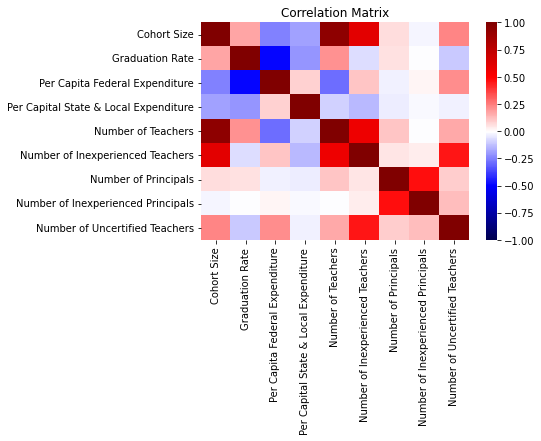

In [46]:
corr_matrix = model_df.copy()
corr_matrix = corr_matrix.rename(columns={'COHORT_COUNT': 'Cohort Size',
                                          'GRAD_RATE': 'Graduation Rate', 
                                          'PER_FEDERAL_EXP': 'Per Capita Federal Expenditure', 
                                          'PER_STATE_LOCAL_EXP': 'Per Capital State & Local Expenditure',
                                          'NUM_TEACH': 'Number of Teachers', 
                                          'NUM_TEACH_INEXP': 'Number of Inexperienced Teachers', 
                                          'NUM_PRINC': 'Number of Principals', 
                                          'NUM_PRINC_INEXP': 'Number of Inexperienced Principals', 
                                          'NUM_OUT_CERT': 'Number of Uncertified Teachers'})
corr_matrix = corr_matrix.loc[:, ~corr_matrix.columns.isin(['INSTITUTION_ID', 'ENTITY_CD', 'YEAR', 'OVERALL_STATUS'])].corr()

fig, ax = plt.subplots()
sns.heatmap(corr_matrix, vmin=-1, vmax=1,
            ax=ax, cmap='seismic')
ax.set_title('Correlation Matrix')
plt.show()

## Graduation Rate Histogram
<a class='anchor' id='grad-rate-hist'></a>

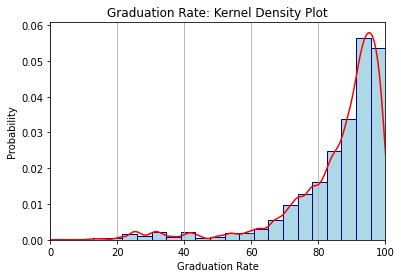

In [47]:
fig, ax = plt.subplots()

model_df['GRAD_RATE'].plot.kde(bw_method=0.1, 
                               ax=ax, legend=False, color='red',
                               title='Graduation Rate: Kernel Density Plot')
model_df['GRAD_RATE'].hist(edgecolor='#00008b', color='#ADD8E6', bins=20, density=True, ax=ax)
ax.set_ylabel('Probability')
ax.set_xlabel('Graduation Rate')
ax.set_xlim([0, 100])
ax.grid(axis='y')

plt.show()

## Funding per Student Boxenplot
<a class='anchor' id='fund-per-student-boxen'></a>

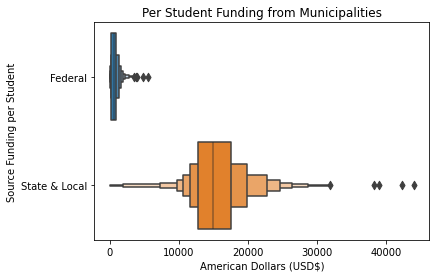

In [48]:
boxenplot_df = model_df.copy()[['PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP']]
boxenplot_df = pd.melt(boxenplot_df)

boxen_plot_labels_dict = {'PER_FEDERAL_EXP': 'Federal', 
                          'PER_STATE_LOCAL_EXP': 'State & Local'}
boxenplot_df['variable'] = boxenplot_df['variable'].map(boxen_plot_labels_dict)


fig, ax = plt.subplots()
sns.boxenplot(data=boxenplot_df, x='value', y='variable', ax=ax)
ax.set_ylabel('Source Funding per Student')
ax.set_xlabel('American Dollars (USD$)')
ax.set_title('Per Student Funding from Municipalities')
plt.show()

## Graduation Rate by Funding per Student
<a class='anchor' id='grad-rate-fund-per-student'></a>

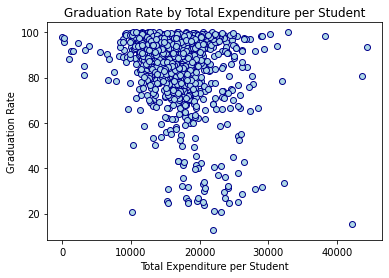

In [49]:
fig, ax = plt.subplots()
ax.scatter(x=model_df[['PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP']].sum(axis=1), 
           y=model_df['GRAD_RATE'], 
           edgecolor='#00008b', color='#ADD8E6')
ax.set_ylabel('Graduation Rate')
ax.set_xlabel('Total Expenditure per Student')
ax.set_title('Graduation Rate by Total Expenditure per Student')

plt.show()

## PCA
<a class='anchor' id='pca'></a>

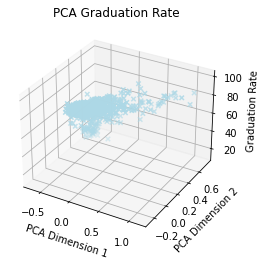

PCA Explained Variance: 0.555


In [50]:
fig_PCA = PCA(n_components=2)
pca_minmax_enc = MinMaxScaler()
pca_minmaxed_data = pca_minmax_enc.fit_transform(model_df[['COHORT_COUNT', 'GRAD_RATE', 'PER_FEDERAL_EXP', 
                                                           'PER_STATE_LOCAL_EXP',
                                                           'NUM_TEACH', 'NUM_TEACH_INEXP', 'NUM_PRINC',
                                                           'NUM_PRINC_INEXP', 'NUM_OUT_CERT']])
pca_processed_matrix = fig_PCA.fit_transform(pca_minmaxed_data)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_processed_matrix[:, 0],
           pca_processed_matrix[:, 1],
           model_df['GRAD_RATE'],
           edgecolor='#00008b', color='#ADD8E6',
           marker='x')

ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('Graduation Rate')
ax.set_title('PCA Graduation Rate')

plt.show()
print(f'PCA Explained Variance: {np.round(fig_PCA.explained_variance_ratio_.sum(), 3)}')

## Overall Status - Pie Chart 
<a class='anchor' id='overall-status-pie'></a>

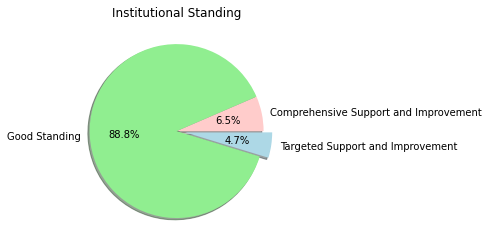

In [51]:
overall_status_df = model_df.copy()[['OVERALL_STATUS']]
overall_status_df['Representation'] = 1

overall_status_df = overall_status_df.groupby('OVERALL_STATUS', as_index=False).sum()
overall_status_df = overall_status_df.rename(columns={'OVERALL_STATUS': 'Institutional Standing'})


fig, ax = plt.subplots()
ax.pie(labels=overall_status_df['Institutional Standing'], 
       x=overall_status_df['Representation'],
       autopct='%1.1f%%', explode=[0, 0, 0.1], 
       colors=['#ffcccb', '#90EE90', '#ADD8E6'], shadow=True)

ax.set_title('Institutional Standing')

plt.show()

## Teacher Representation
<a class='anchor' id='teacher-representation'></a>

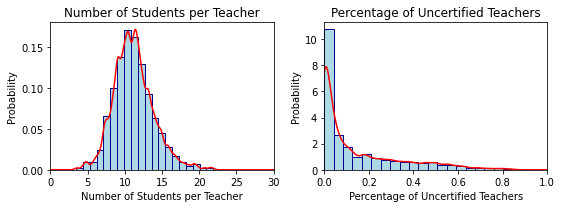

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

(model_df['COHORT_COUNT']/model_df['NUM_TEACH']).plot.kde(bw_method=0.1, 
                               ax=ax1, legend=False, color='red',
                               title='Number of Students per Teacher')
(model_df['COHORT_COUNT']/model_df['NUM_TEACH']).hist(edgecolor='#00008b', color='#ADD8E6', bins=20, 
                                                      density=True, ax=ax1)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Number of Students per Teacher')
ax1.set_xlim([0, 30])
ax1.grid()

(model_df['NUM_OUT_CERT']/model_df['NUM_TEACH']).plot.kde(bw_method=0.1, 
                                                          ax=ax2, legend=False, color='red',
                                                          title='Percentage of Uncertified Teachers')
((model_df['NUM_OUT_CERT']/model_df['NUM_TEACH'])).hist(edgecolor='#00008b', color='#ADD8E6', bins=20, 
                                                        density=True, ax=ax2)
ax2.set_ylabel('Probability')
ax2.set_xlabel('Percentage of Uncertified Teachers')
ax2.set_xlim([0, 1])
ax2.grid()


plt.show()

# Model Creation & Predicition
<a class='anchor' id='model-creation-prediction'></a>

## Train-Test Split
<a class='anchor' id='train-test-split'></a>

In [11]:
X = model_df.loc[:, model_df.columns != 'GRAD_RATE']
y = model_df['GRAD_RATE']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=255)

## Composite Model
<a class='anchor' id='composite-model'></a>

In [13]:
class compositeModel:
    def __init__(self, sklearn_model):
        self.clf = sklearn_model
        self.scalers_trained = False
        self.model_trained = False
        
    def _train_scalers(self, x):
        self.clf_scaler = MinMaxScaler()
        self.clf_scaler.fit(x[['COHORT_COUNT', 'PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP',
                               'TeachersPerPupil', 'InexpTeachersPerPupil', 'InexpTeachersPerTeacher', 
                               'PrincipalsperPupil', 'InexpPrincipalsPerPupil', 'InexpPrincipalsPerPrincipal',
                               'OutofCertTeachersPerPupil', 'OutofCertTeachersPerTeacher']])
        self.overall_status_one_hot_enc = OneHotEncoder()
        self.overall_status_one_hot_enc.fit(x[['OVERALL_STATUS']].to_numpy())
        self.scalers_trained = True
    
    def _x_preprocessing(self, x, training=True):
        try:
            x = x[['OVERALL_STATUS', 'COHORT_COUNT',
                   'PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP',
                   'NUM_TEACH', 'NUM_TEACH_INEXP', 
                   'NUM_PRINC', 'NUM_PRINC_INEXP',
                   'GROUP_NAME', 'NUM_OUT_CERT']].copy()
        except KeyError:
            print('Incorrect dependent variables.')
            return False
        
        # Feature Engineering
        x['TeachersPerPupil'] = x['NUM_TEACH']/x['COHORT_COUNT']
        x['InexpTeachersPerPupil'] = x['NUM_TEACH_INEXP']/x['COHORT_COUNT']
        x['InexpTeachersPerTeacher'] = x['NUM_TEACH_INEXP']/x['NUM_TEACH']
        
        x['PrincipalsperPupil'] = x['NUM_PRINC']/x['COHORT_COUNT']
        x['InexpPrincipalsPerPupil'] = x['NUM_TEACH_INEXP']/x['COHORT_COUNT']
        x['InexpPrincipalsPerPrincipal'] = x['NUM_PRINC_INEXP']/x['NUM_PRINC']
        x['OutofCertTeachersPerPupil'] = x['NUM_OUT_CERT']/x['COHORT_COUNT']
        x['OutofCertTeachersPerTeacher'] = x['NUM_OUT_CERT']/x['NUM_TEACH']
        
        x = x.replace(np.inf, 1)
        x = x.replace(np.NINF, 0)
        x = x.fillna(0)  # Divide by zero errors come through as NULL, this fills these with zeros
        
        features_minmax_scaled = ['COHORT_COUNT', 'PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP',
                                  'TeachersPerPupil', 'InexpTeachersPerPupil', 
                                  'InexpTeachersPerTeacher', 'PrincipalsperPupil', 'InexpPrincipalsPerPupil',
                                  'InexpPrincipalsPerPrincipal', 'OutofCertTeachersPerPupil', 
                                  'OutofCertTeachersPerTeacher']
        features_onehot_encoded = ['OVERALL_STATUS']
        features_to_be_scaled = [features_minmax_scaled, features_onehot_encoded]
        features_to_be_scaled = [item for sublist in features_to_be_scaled for item in sublist]
        
        if training:
            self._train_scalers(x[features_to_be_scaled])
                            
        x[features_minmax_scaled] = self.clf_scaler.transform(x[features_minmax_scaled]) 
        x[self.overall_status_one_hot_enc.categories_[0].tolist()] = self.overall_status_one_hot_enc.transform(x[['OVERALL_STATUS']].to_numpy()).toarray()
        
        preprocessed_features = [features_minmax_scaled, 
                                 self.overall_status_one_hot_enc.categories_[0].tolist()]
        preprocessed_features = [item for sublist in preprocessed_features for item in sublist]
        
        return x[preprocessed_features]
    
    def fit(self, x_train, y_train):
        x_train = x_train.copy()
        x_train = self._x_preprocessing(x_train, training=True)
        self.clf.fit(X=x_train, y=y_train)
        self.model_trained = True
        return self.clf
    
    def predict(self, x_test):
        if not self.model_trained:
            print('Train the model.')
            return False
        x_test = self._x_preprocessing(x_test, training=False)
        predictions = self.clf.predict(x_test)
        return predictions

In [14]:
def return_model_accuracy(y_true, y_pred):
    predictions_max_error = max_error(y_true=y_test, y_pred=predictions)
    predictions_mean_absolute_error = mean_absolute_error(y_true=y_test, y_pred=predictions)
    predictions_mean_squared_error = mean_squared_error(y_true=y_test, y_pred=predictions)
    predictions_median_absolute_error = median_absolute_error(y_true=y_test, y_pred=predictions)

    print(f'Max Error: {round(predictions_max_error, 3)}')
    print(f'Mean Absolute Error: {round(predictions_mean_absolute_error, 3)}')
    print(f'Mean Squared Error: {round(predictions_mean_squared_error, 3)}')
    print(f'Median Squared Error: {round(predictions_median_absolute_error, 3)}')
    
    result_dict = {
        'Max Error': predictions_max_error,
        'Mean Absolute Error': predictions_mean_absolute_error,
        'Mean Sqaured Error': predictions_mean_squared_error,
        'Median Squared Error': predictions_median_absolute_error
    }
    return result_dict

## Model Creation
<a class='anchor' id='model-creation'></a>

In [15]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

In [16]:
# Elastic Net
grid_params = {
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
    'l1_ratio': np.arange(0, 1, 0.01)
}
grid_model = GridSearchCV(ElasticNet(), grid_params, scoring='neg_median_absolute_error', cv=cv, n_jobs=-1)

In [17]:
model = compositeModel(sklearn_model=grid_model)
model.fit(X_train, y_train)
print(model.clf.best_estimator_)

predictions = model.predict(X_test)
accuracy_metrics = return_model_accuracy(y_true=y_test, y_pred=predictions)

ElasticNet(alpha=0.0001, l1_ratio=0.98)
Max Error: 48.865
Mean Absolute Error: 7.422
Mean Squared Error: 119.415
Median Squared Error: 5.147


/home/dcaramel/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.336e+03, tolerance: 1.850e+01
  model = cd_fast.enet_coordinate_descent(


In [24]:
# SVR
grid_params = {
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': np.arange(3, 7, 1),
    'C': np.arange(0.0001, 1, 0.01)
}
grid_model = GridSearchCV(SVR(), grid_params, scoring='neg_median_absolute_error', cv=cv, n_jobs=-1)

In [25]:
model = compositeModel(sklearn_model=grid_model)
model.fit(X_train, y_train)
print(model.clf.best_estimator_)

predictions = model.predict(X_test)
accuracy_metrics = return_model_accuracy(y_true=y_test, y_pred=predictions)

SVR(C=0.9901, degree=5, kernel='poly')
Max Error: 66.081
Mean Absolute Error: 6.571
Mean Squared Error: 115.972
Median Squared Error: 3.863


In [62]:
# AdaBoost Regressor
grid_params = {
    'n_estimators': np.arange(60, 301, 20),
    'learning_rate': np.arange(0.1, 2.6, 0.1)
}
grid_model = GridSearchCV(AdaBoostRegressor(), grid_params, scoring='neg_median_absolute_error', cv=cv, n_jobs=-1)

In [63]:
model = compositeModel(sklearn_model=grid_model)
model.fit(X_train, y_train)
print(model.clf.best_estimator_)

predictions = model.predict(X_test)
accuracy_metrics = return_model_accuracy(y_true=y_test, y_pred=predictions)

AdaBoostRegressor(learning_rate=0.1, n_estimators=60)
Max Error: 57.092
Mean Absolute Error: 7.677
Mean Squared Error: 115.976
Median Squared Error: 6.216


In [64]:
# RandomForest Regressor
grid_params = {
    'max_depth': np.arange(2, 21, 2),
    'n_estimators': np.arange(60, 301, 20) 
}
grid_model = GridSearchCV(RandomForestRegressor(), grid_params, scoring='neg_median_absolute_error', cv=cv, n_jobs=-1)

In [65]:
model = compositeModel(sklearn_model=grid_model)
model.fit(X_train, y_train)
print(model.clf.best_estimator_)

predictions = model.predict(X_test)
accuracy_metrics = return_model_accuracy(y_true=y_test, y_pred=predictions)

RandomForestRegressor(max_depth=10)
Max Error: 59.806
Mean Absolute Error: 6.375
Mean Squared Error: 94.969
Median Squared Error: 4.31


In [66]:
# MLP Regressor
grid_params = {
    'hidden_layer_sizes': [(100,), (50,100,), (50,75,100,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate' : ['constant', 'adaptive', 'invscaling']
}
grid_model = GridSearchCV(MLPRegressor(), grid_params, scoring='neg_median_absolute_error', cv=cv, n_jobs=-1)

In [67]:
model = compositeModel(sklearn_model=grid_model)
model.fit(X_train, y_train)
print(model.clf.best_estimator_)

predictions = model.predict(X_test)
accuracy_metrics = return_model_accuracy(y_true=y_test, y_pred=predictions)

/home/dcaramel/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [ -5.42292396  -5.62425874 -12.28567051  -5.42306279  -5.60280952
 -12.28179224  -5.42301265  -7.67448807 -12.31982381  -5.42288595
          nan  -5.54430114  -5.42284658          nan  -5.48097268
  -5.42282301  -5.98191482  -5.4541349   -5.42325464          nan
  -5.48162088  -5.42364365          nan  -5.45013694  -5.42286342
          nan  -5.43248907  -5.1795508   -5.54637295 -25.63104392
  -5.12640673  -5.54432907 -25.51281876  -5.24158184  -5.25671255
 -25.57620478  -5.14819604  -5.53216274 -26.96170663  -5.21502858
  -5.54562867 -26.76556065  -5.24290072 -20.39867481 -26.70563096
  -5.25783673  -6.65626845 -35.83502878  -5.18438764  -5.73485912
 -34.93360161  -5.33474768 -24.63811453 -35.86902215  -5.2072781
  -5.39612723 -15.75766114  -5.16683196  -5.47153221 -15.7757362
  -5.16907265  -8.88452702 -15.79357134  -4.95269025  -5.624

MLPRegressor(hidden_layer_sizes=(50, 75, 100), learning_rate='adaptive',
             solver='lbfgs')
Max Error: 57.179
Mean Absolute Error: 7.235
Mean Squared Error: 120.632
Median Squared Error: 4.83


/home/dcaramel/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Evaulation
<a class='anchor' id='evaulation'></a>

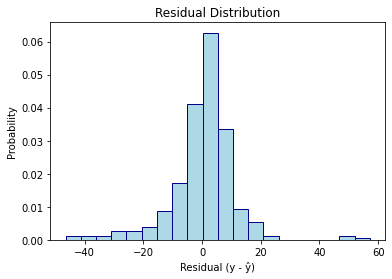

In [68]:
fig, ax = plt.subplots()

ax.hist(x=(y_test-predictions),
        bins=20, density=True,
        edgecolor='#00008b', color='#ADD8E6')

ax.set_ylabel('Probability')
ax.set_xlabel('Residual (y - ŷ)')
ax.set_title('Residual Distribution')
plt.show()

In [19]:
def wire_mesh_prediction(mesh_grid, predictions, x_feature_name, y_feature_name, xlabel, ylabel):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    ax.plot_wireframe(mesh_grid[x_feature_name], mesh_grid[y_feature_name], predictions.reshape(-1, 1),
                      label='Predictions', cstride=2, color='maroon')

    ax.legend(loc='upper right')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel('Graduation Rate')
    ax.set_title('Predictions Mesh Grid')
    return fig

<IPython.core.display.Javascript object>


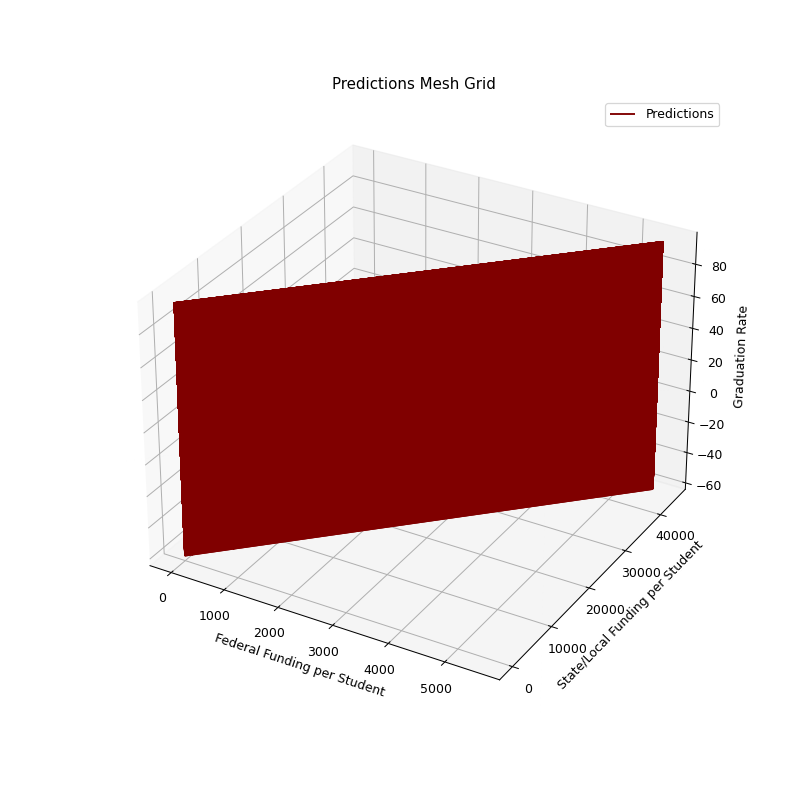

In [26]:
%matplotlib notebook
mesh_sample = 1000
mesh_grid_array = model_df[['COHORT_COUNT', 
                            'PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP',
                            'NUM_TEACH', 'NUM_TEACH_INEXP', 'NUM_PRINC', 
                            'NUM_PRINC_INEXP', 'NUM_OUT_CERT']].copy()
mesh_grid_array_columns = mesh_grid_array.columns

mesh_grid_array = np.linspace(start=mesh_grid_array.max(axis=0),
                              stop=mesh_grid_array.min(axis=0),
                              endpoint=True,
                              num=mesh_sample)
mesh_grid_array = pd.DataFrame(mesh_grid_array, columns=mesh_grid_array_columns)
mesh_grid_array['OVERALL_STATUS'] = np.random.choice(a=model_df['OVERALL_STATUS'].unique(), size=mesh_sample)
mesh_grid_array['GROUP_NAME'] = np.random.choice(a=model_df['GROUP_NAME'].unique(), size=mesh_sample)


wire_mesh_predictions = model.predict(mesh_grid_array)

wire_mesh_prediction(mesh_grid=mesh_grid_array, predictions=wire_mesh_predictions, 
                     x_feature_name='PER_FEDERAL_EXP', y_feature_name='PER_STATE_LOCAL_EXP', 
                     xlabel='Federal Funding per Student', ylabel='State/Local Funding per Student')
plt.show()